In [3]:
import time
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import numpy as np
from torchvision import transforms
import torch
from tqdm import tqdm
from spikingjelly.activation_based import neuron, functional, surrogate , encoding , layer
import math
from numba import jit , prange
from numba.typed import List
import pyspike as spk

In [4]:
## Download datasets
train_dataset = torchvision.datasets.MNIST(
    root = "'./data'",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True
)


## DataLoaders
train_data_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size = 32,
    shuffle=True,
    drop_last=True,
    pin_memory=True
)


test_data_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    pin_memory=True
)



In [5]:
class SNN(nn.Module):
    def __init__(self):
        super().__init__()

        
        self.flatten = layer.Flatten()
        self.fc1 = layer.Linear(28*28, 50, bias=False) # Input
        self.lif1 = neuron.LIFNode(tau=3.0, surrogate_function=surrogate.ATan())
        self.fc2 = layer.Linear(50, 10, bias=False) # Input
        self.lif2 = neuron.LIFNode(tau=3.0, surrogate_function=surrogate.ATan())
        

    def forward(self, x: torch.Tensor):

        x = self.flatten(x)
        x = self.lif1(self.fc1(x))
        self.s_layer1 = x
        x = self.lif2(self.fc2(x))
        self.s_layer2 = x
        
        '''
        x = self.lif3(self.fc3(x))
        self.s_layer3 = x
        x = self.lif4(self.fc4(x))
        '''
        
        return x , self.s_layer1

In [6]:

ls_synchrony10 = []

for i in range(1 , 36):

    synchrony = SNN()  # Create an instance of your model class
    synchrony.load_state_dict(torch.load(f'/Users/manivaziri/Desktop/Models0/synchrony10/model_synchrony{i}.pt'))
    synchrony.eval()  # Set the model to evaluation mode

    ls_synchrony10.append(synchrony)



In [7]:

ls_synchrony8 = []

for i in range(0 , 4):

    synchrony = SNN()  # Create an instance of your model class
    synchrony.load_state_dict(torch.load(f'/Users/manivaziri/Desktop/Models0/synchrony8/model_new_synchrony{i}.pt'))
    synchrony.eval()  # Set the model to evaluation mode

    ls_synchrony8.append(synchrony)



In [8]:

ls_sparsity = []

for i in range(1 , 42):

    synchrony = SNN()  # Create an instance of your model class
    synchrony.load_state_dict(torch.load(f'/Users/manivaziri/Desktop/Models0/sparsity/model_sparsity_record{i}.pt'))
    synchrony.eval()  # Set the model to evaluation mode

    ls_sparsity.append(synchrony)



In [9]:
len(ls_sparsity)

41

In [10]:
len(ls_synchrony10)

35

In [11]:
len(ls_synchrony8)

4

In [45]:
def t_out(out_t , T , label , results):
    
    for t in range(1 , T+1):

        out_fr = (torch.sum(out_t[ : , : , 0:t] , 2)/t)
        results[t-1]  = results[t-1] + (out_fr.argmax(1)==label).float().sum().item()


    return results

In [50]:
def getting_results(ls):

    encoder = encoding.PoissonEncoder()
    T = 30
    results = []

    for model in ls :

        with torch.no_grad():
        
        
                    test_samples =0
                    test_loss = 0
                    test_acc = 0
                    train_time = time.time()
                    totallayer1_spikes = 0
                    time_rs = torch.zeros([T])

            
                    for img, label in train_data_loader:
                        label_onehot = F.one_hot(label, 10).float()
                        out_fr = 0
        
                        for t in range(T):
                            encoded_img = encoder(img)
                            out , layer1_spikes = model(encoded_img)
                            out_fr += out
                            totallayer1_spikes += torch.sum(layer1_spikes)
                            layers_spikes2 = out.unsqueeze(2)
                            
                            
                            if t == 0 :

                                  slayer2 = layers_spikes2
                                    
                                  '''
                                  slayer3 = layers_spikes3
                                  '''
        
                            else :
        
                              
                                  slayer2 = torch.cat((slayer2, layers_spikes2), dim=2)
                                  
                                  '''
                                  slayer3 =  torch.cat((slayer3, layers_spikes3), dim=2)
                                  '''
                                    


                        time_rs = t_out(slayer2 , T , label , time_rs)
                        out_fr = out_fr/T
                        loss = F.mse_loss(out_fr, label_onehot)
                
                        test_samples += label.numel()
                        test_loss += loss.item()*label.numel()
                        test_acc += (out_fr.argmax(1)==label).float().sum().item()
                        functional.reset_net(model)

                        
                        
                    test_time = time.time()
                    test_speed = test_samples/(test_time - train_time)
                    test_loss /= test_samples
                    test_acc /= test_samples

                    results.append([test_acc , totallayer1_spikes , time_rs/test_samples])


    return results

In [51]:
rs1 = getting_results(ls_synchrony10)

In [52]:
rs2 = getting_results(ls_sparsity)

In [15]:
#rs3 = getting_results(ls_synchrony8)

In [75]:
rs2[15]

[0.9877,
 tensor(4883876.),
 tensor([0.6579, 0.8881, 0.9497, 0.9687, 0.9758, 0.9795, 0.9821, 0.9832, 0.9840,
         0.9847, 0.9852, 0.9852, 0.9857, 0.9857, 0.9860, 0.9862, 0.9865, 0.9867,
         0.9870, 0.9872, 0.9871, 0.9874, 0.9873, 0.9873, 0.9875, 0.9876, 0.9875,
         0.9876, 0.9876, 0.9877])]

In [77]:
rs1[7]

[0.9887833333333333,
 tensor(4908014.),
 tensor([0.7282, 0.9034, 0.9572, 0.9726, 0.9788, 0.9816, 0.9839, 0.9845, 0.9861,
         0.9865, 0.9870, 0.9870, 0.9872, 0.9874, 0.9876, 0.9879, 0.9880, 0.9880,
         0.9884, 0.9883, 0.9884, 0.9885, 0.9885, 0.9885, 0.9886, 0.9886, 0.9887,
         0.9887, 0.9886, 0.9888])]

In [ ]:
rs1[8]

In [ ]:
(2.3*10**9)

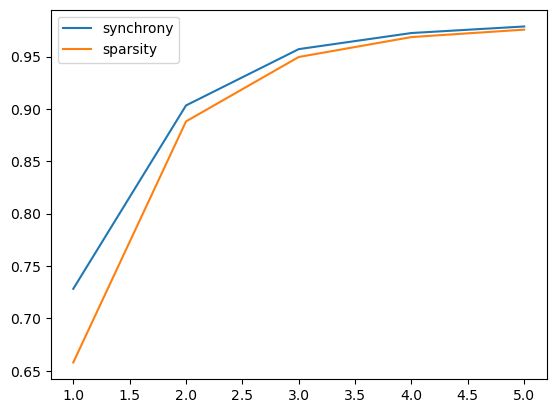

In [78]:
t = [i for i in range(1 , 31)]
plt.plot(t[0:5], rs1[7][2][0:5] , label = "synchrony")
plt.plot(t[0:5] , rs2[15][2][0:5] , label = "sparsity")
plt.legend()
plt.show()

## 

In [18]:
xrs1 = []
yrs1 = []


for result in rs1:

    xrs1.append(result[1].reshape(-1 , 1))
    yrs1.append(result[0])



In [19]:
xrs2 = []
yrs2 = []


for result in rs2:

    xrs2.append(result[1].reshape(-1 , 1))
    yrs2.append(result[0])



In [318]:
xrs3

[tensor([[8602342.]]),
 tensor([[7000314.]]),
 tensor([[7204089.]]),
 tensor([[6371923.]])]

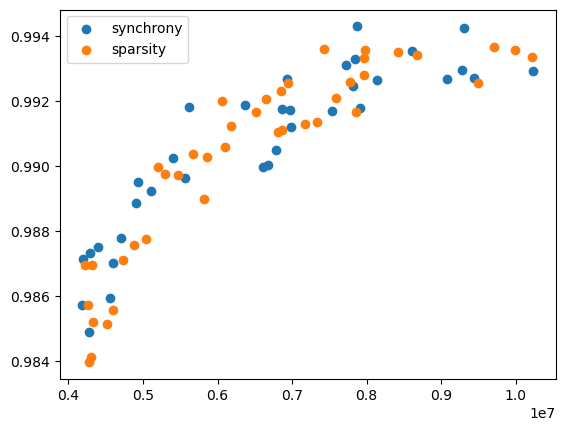

In [21]:
plt.scatter(xrs1 , yrs1 , label = "synchrony")
plt.scatter(xrs2 , yrs2 , label = "sparsity")
#plt.scatter(xrs3 , yrs3 , label = "sparsity")
plt.legend()
plt.show()

In [23]:
from sklearn.linear_model import LinearRegression


In [33]:
x1 = torch.tensor(xrs1, dtype=torch.float32)

In [34]:
y1 = torch.tensor(yrs1, dtype=torch.float32)

In [35]:
x2 = torch.tensor(xrs2, dtype=torch.float32)
y2 = torch.tensor(yrs2, dtype=torch.float32)
#x3 = torch.tensor(xrs3, dtype=torch.float32)
#y3 = torch.tensor(yrs3, dtype=torch.float32)

In [36]:
selected1 = x1<6.5*10**6
selected2 = x2<6.5*10**6

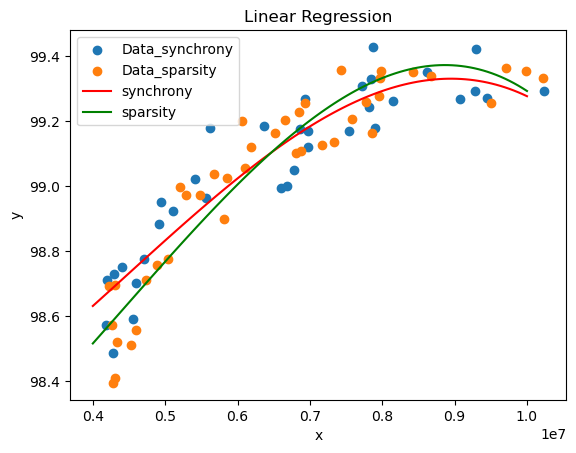

In [37]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

x1 = x1.reshape(-1, 1)
x2 = x2.reshape(-1, 1)
y1 = y1
y2 = y2

degree = 3  # Set the degree of the polynomial curve
polynomial_features = PolynomialFeatures(degree=degree)
x_poly1 = polynomial_features.fit_transform(x1)

polynomial_features = PolynomialFeatures(degree=degree)
x_poly2 = polynomial_features.fit_transform(x2)

# Create a linear regression model and fit the data
model1 = LinearRegression()
model1.fit(x_poly1, y1)

model2 = LinearRegression()
model2.fit(x_poly2, y2)

# Get the coefficients and intercept
slope1 = model1.coef_[0]
slope2 = model2.coef_[0]

intercept1 = model1.intercept_
intercept2 = model2.intercept_

# Generate the predicted y values

x_range = np.linspace(0.4 * 10**7, 10**7, 100)
x_range_poly = polynomial_features.transform(x_range.reshape(-1, 1))
y_range1 = model1.predict(x_range_poly)
y_range2 = model2.predict(x_range_poly)


# Plot the data points and the fitted line
plt.scatter(x1, y1*100, label='Data_synchrony')
plt.scatter(x2, y2*100, label='Data_sparsity')

plt.plot(x_range, y_range1*100, color='red', label='synchrony')
plt.plot(x_range, y_range2*100, color='green', label='sparsity')

plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()

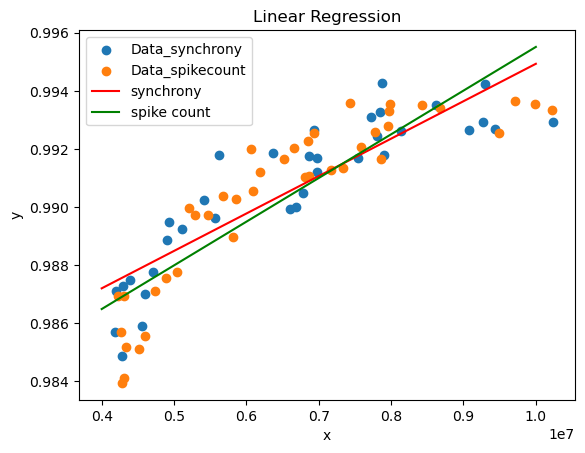

In [39]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Reshape the input data to fit the sklearn API


# Create a linear regression model and fit the data
model1 = LinearRegression()
model1.fit(x1, y1)

model2 = LinearRegression()
model2.fit(x2, y2)

# Get the coefficients and intercept
slope1 = model1.coef_[0]
intercept1 = model1.intercept_


slope2 = model2.coef_[0]
intercept2 = model2.intercept_

# Generate the predicted y values
x_range = np.linspace(0.4 * 10**7, 1*10**7, 100)
y_range1 = slope1 * x_range + intercept1

y_range2 = slope2 * x_range + intercept2

# Plot the data points and the fitted line
plt.scatter(x1, y1, label='Data_synchrony')
plt.scatter(x2, y2, label='Data_spikecount')

plt.plot(x_range, y_range1, color='red', label="synchrony")
plt.plot(x_range, y_range2, color='green', label='spike count')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Linear Regression')
plt.legend()
plt.show()